In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from transport_nets.models import NVP
from transport_nets.distributions import BananaFlow

from tqdm import trange

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
#target data
num_samples = 10000
params = (0.5,0.1,0.05,0.0)
bFlow = BananaFlow(params)
target = bFlow.sample(num_samples)

# Create model object
nvp = NVP(output_dim=2,num_layers=6,num_masked=1, neuron_list=[100,100])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08)
nvp.compile(opt)

# Define training options
n_epochs = 50
batch_size = 200

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/50
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


KeyboardInterrupt: 

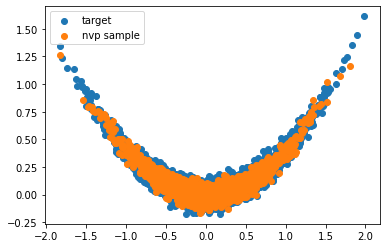

In [3]:
# checking that nvp learned joint distribution 
nvp_sample = nvp.sample(2000)
plt.scatter(target[:,0],target[:,1],label='target')
plt.scatter(nvp_sample[:,0],nvp_sample[:,1],label='nvp sample')
plt.legend()

### Pre-Conditioner Training Scheme
Have already trained invertible generator $f$. Want to train
pre-generator $\hat{f}$ to get conditional samples $x_1 \sim p(x_1|x_2=x_2^*)$.

<img src="images/pre-conditioner-training-diagram.png" width=600px>

Want to fit composed flow model $f\circ \hat{f}$ to smoothed distribution $p(x_1,x_2 | \hat{x_2} = x_2^*)$. By minimizing KL divergence between two distributions the objective function becomes
<img src="images/pre-conditioner-objective.png" width=400px>

loss: 31.730 :   0%|          | 0/50 [00:07<?, ?it/s]

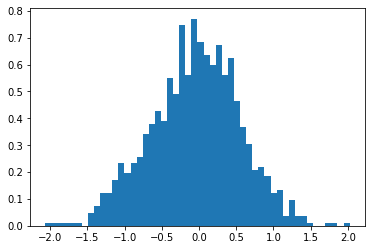

loss: 17.472 :  20%|██        | 10/50 [00:44<02:32,  3.82s/it]

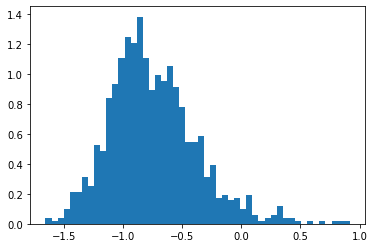

loss: nan :  38%|███▊      | 19/50 [01:16<01:50,  3.57s/it]                      Exception ignored in: <generator object tqdm.__iter__ at 0x7f44fc048a40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1183, in __iter__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1271, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 572, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 53, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [9]:
# will have to consider multiple dimensions in x2 for future 
NormalDist = tfd.MultivariateNormalDiag(loc=[0.0,0.0], scale_diag=[1.0,1.0]) #standard normal distribution 
@tf.function
def pre_cond_train(f,f_hat,x2_obs,sigma,batch_size,opt):
    z0 = NormalDist.sample(batch_size)
    with tf.GradientTape() as tape:
        z1 = f_hat(z0)
        loss = tf.reduce_mean(f_hat.log_prob(z1) - NormalDist.log_prob(z1)
               + 1.0/(2.0*sigma**2)*tf.norm(f(z1)[:,1:2]-x2_obs,axis=-1)**2) 
    gradients = tape.gradient(loss, f_hat.trainable_variables)
    opt.apply_gradients(zip(gradients, f_hat.trainable_variables))
    return loss

#pre-conditioner (structured noise)
nvp_pre = NVP(output_dim=2,num_layers=4,num_masked=1,neuron_list=[100,100])
_ = nvp_pre.sample(1000)

# Adam optimizer parameters
lr = 1e-5
beta_1 = 0.9
beta_2 = 0.999
opt_pre = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=1e-6)
# whitening noise
sigma_w = 0.05 
x2_obs = 0.5

batch_size_pre = 200
num_epochs_pre = 50
t = trange(num_epochs_pre)
for epoch in t:
    for batch in dataset:
        loss = pre_cond_train(nvp,nvp_pre,x2_obs,sigma_w,batch_size_pre,opt_pre)
        t.set_description("loss: %0.3f " % loss.numpy())
        t.refresh()
    if epoch % 5 == 0:
        z0 = NormalDist.sample(1000)
        z1 = nvp_pre(z0)
        x = nvp(z1)
        plt.hist(x[:,0],50,density=True, label='conditional samples')
        plt.pause(0.05)
nvp_pre.batch_norm_mode(False)